In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 10
plt.style.use("ggplot")
mpl.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = 'NanumGothic'

train = pd.read_csv('/home/yahwang/elice/titanic_train.csv')

## 결측치의 종류

1. MCAR ( Missing Completely At Random ) : 완전 무작위인 결측치

2. MAR ( Missing At Random ) : 임의적인 결측치

3. NI (Non-ignorable) : 무시할 수 없는 결측치

## 결측치 확인

In [2]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
              ... 
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Length: 12, dtype: int64

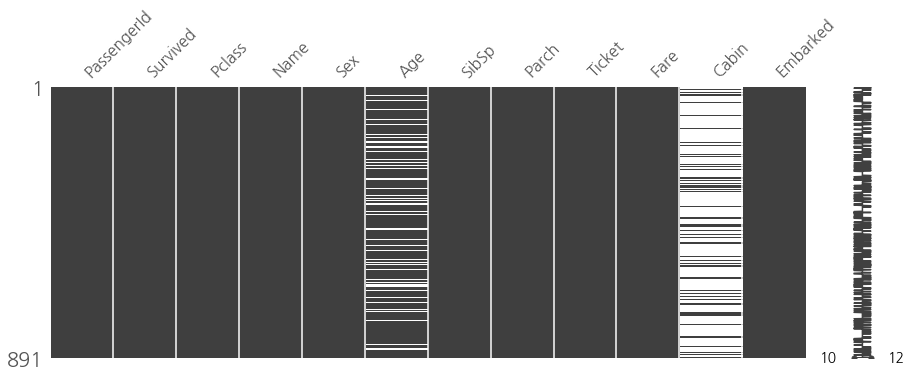

In [211]:
# missingno 모듈을 통해 시각화
import missingno as msno
msno.matrix(train, figsize=(15,5))

#### 참고 : 결측치에는 NaN, NAN, nan이 존재한다. 이 들은 값 자체가 없기 때문에 서로 다른 값으로 인식한다. (자기 자신도 포함)

In [3]:
from numpy import NaN, NAN, nan
print( 'NaN == NaN {} '.format(NaN == NaN), '|  NaN == NAN {} '.format(NaN == NAN), '|  NaN == nan {}'.format(NaN == nan) )

NaN == NaN False  |  NaN == NAN False  |  NaN == nan False


# 결측치를 처리하는 방법

## 1. 결측치를 제거하고 계산하기

### NA데이터가 MCAR이라는 가정이 있어야 한다??

#### listwise deletion : NA값이 포함된 모든 row를 제외하고 계산하는 방법

In [215]:
train.dropna(how='any').shape # row 중에 하나라도 nan이 존재하면 삭제
train.dropna(how='all').shape # row의 모든 값이 nan일 때 삭제

(183, 12)

#### pairwise deletion : 계산에 필요한 feature에서만 해당 row를 제외하고 계산하는 방법
    변수 선정에 따라 sample 수가 다를 수 있다.
    
    단점에 대한 이해가 필요
    

## 2. 결측치 대체값으로 채우기 ( Imputation )

863, 868번 ROW가 NaN 값을 가지고 있다.

In [164]:
train2 = train.copy()
fill_df = train2.loc[862:870,['PassengerId','Age']]
fill_df

,PassengerId,Age
862,863,48.0
863,864,NaN
864,865,24.0
865,866,42.0
866,867,27.0
867,868,31.0
868,869,NaN
869,870,4.0
870,871,26.0


### 1. 특정값으로 채우기 ( mean, median, mode ... )

In [85]:
fill_df.fillna(100) # 100으로 대체
fill_df.fillna(train2['Age'].mode()[0]) # mod(최빈값)으로 대체

,PassengerId,Age
862,863,48.0
863,864,24.0
864,865,24.0
865,866,42.0
866,867,27.0
867,868,31.0
868,869,24.0
869,870,4.0
870,871,26.0


In [217]:
# Scikit-learn 활용
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median') # mean, most_frequent(mod)
# 2차원 이상의 배열이 필요(tensor처럼)
b = imp.fit_transform( fill_df.Age.values.reshape(-1,1) ) # 하나의 array에 대해서는 reshape이 필요
# fill_df.Age = b.reshape(-1) # 데이터 프레임에 적용

### 2. 앞 뒤 value의 관계를 활용하여 채우기 

In [6]:
fill_df.fillna(method='ffill') # 앞의 값으로 대체
# fill_df.fillna(method='bfill') # 뒤의 값으로 대체

,PassengerId,Age
862,863,48.0
863,864,48.0
864,865,24.0
865,866,42.0
866,867,27.0
867,868,31.0
868,869,31.0
869,870,4.0
870,871,26.0


In [7]:
fill_df.interpolate(method='linear') # linear는 앞 뒤의 평균값으로 대체한다는 의미

,PassengerId,Age
862,863,48.0
863,864,36.0
864,865,24.0
865,866,42.0
866,867,27.0
867,868,31.0
868,869,17.5
869,870,4.0
870,871,26.0


## nan값을 예측하여 채우기

### 1. Linear Regression으로 채우기

#### e.g. ) NaN으로 존재하는 Age feature의 value를  Linear regression으로 다른 feature를 활용하여 예측

In [66]:
fill_reg_df = train2.loc[:,['Fare', 'SibSp', 'Parch', 'Survived','Age']]
fill_reg_df

,Fare,SibSp,Parch,Survived,Age
0,7.2500,1,0,0,22.0
1,71.2833,1,0,1,38.0
2,7.9250,0,0,1,26.0
3,53.1000,1,0,1,35.0
4,8.0500,0,0,0,35.0
...,...,...,...,...,...
886,13.0000,0,0,0,27.0
887,30.0000,0,0,1,19.0
888,23.4500,1,2,0,NaN
889,30.0000,0,0,1,26.0


In [67]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

train_X = fill_reg_df[fill_reg_df.Age.notnull()].iloc[:,:4]
train_y = fill_reg_df[fill_reg_df.Age.notnull()].Age

reg_model= reg.fit(X=X,y=y)

test_X = fill_reg_df[fill_reg_df.Age.isnull()].iloc[:,:4]
test_y = list(map(round, reg_model.predict(test_X)))
test_y[:10]

[33.0, 30.0, 29.0, 33.0, 29.0, 33.0, 32.0, 29.0, 29.0, 33.0]

### 2. predictive_imputer로  채우기

#### predictive_imputer 모듈은 R의 missforest 패키지를 파이썬으로 구현한 것이다.  ( missforest는 random forest를 활용하여 결측치를 예측 )

In [68]:
import predictive_imputer

In [72]:
predictive_imputer

<module 'predictive_imputer' from '/home/yahwang/.pyenv/versions/3.6.6/lib/python3.6/site-packages/predictive_imputer/__init__.py'>

In [73]:
import numpy as np


In [76]:
X = np.array([[23.56],[53.45],['NaN'],[44.44],[77.78],['NaN'],[234.44],[11.33],[79.87]])

imp = Imputer(missing_values='NaN', strategy=predictive_imputer, axis=0)
imp.fit_transform(X)

print(X)

ValueError: Can only use these strategies: ['mean', 'median', 'most_frequent']  got strategy=<module 'predictive_imputer' from '/home/yahwang/.pyenv/versions/3.6.6/lib/python3.6/site-packages/predictive_imputer/__init__.py'>